In [140]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from enum import Enum
from pathlib import Path
from scipy.interpolate import CubicSpline
from skimage.morphology import skeletonize
import json
import requests 
import io
import base64

### General 

In [141]:
# global last_IVD 
# last_IVD = True
class SegmentationClass(Enum):
    Anterior = 0
    PosteriorA = 1
    PosteriorB = 2
    Vertebrae = 3
    IVD = 4
    Sacrum = 5
    
class LastIVDHolder:
    def __init__(self, value):
        self.value = value
    
def load_image(filename):
    mask =Image.open(filename)
    return np.asanyarray(mask)
    
def load_image_api(filename):
    mask =Image.open(filename)
    return mask    

def image_to_bytes(image):
    # Save the image to a bytes buffer
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format="PNG")  # Save as PNG (or the format of your choice)
    img_byte_arr.seek(0)  # Go to the start of the BytesIO buffer
    return img_byte_arr
    
def convertToCategoricalMasks(mask):
    # mask = np.asanyarray(mask)
    mask = np.copy(mask)
    unique_values = np.unique(mask)
    for i in range(len(unique_values)):
        mask[mask == unique_values[i]] = i
    return mask

def show_binary_mask(image):
    plt.figure()
    plt.imshow(image)
    plt.show()

def show_image(image, title="test"):
    plt.figure()
    # print(image.shape)
    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if len(image.shape) == 3:  # Color image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.imshow(image)
        
    else:  # Grayscale image
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) 
        # print(image.shape)
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

### Paths

In [240]:
masks_dir = '../Datasets/Lumbar spine MRI annotation with IVD height and Pfirrmann grade predictions/Label_384_6SG'
images_dir = '../Datasets/Lumbar spine MRI annotation with IVD height and Pfirrmann grade predictions/Input_384'
pix_spacing_json = './sagittal_pixel_spacing.json'
dumping_drictory  = './sagettal_measurements_output/'
with open(pix_spacing_json, "r") as file:
    data = json.load(file)
Path(dumping_drictory).mkdir(parents=True, exist_ok=True)
images_list = [os.path.join(images_dir, image_name)  for image_name in os.listdir(images_dir)]
mask_list = [os.path.join(masks_dir, mask_name)  for mask_name in os.listdir(masks_dir)]

### Measurements Functions

In [241]:
def getIVDAndPEClass(temp_mask, structure_names = ['IVD', 'Vertebrae', 'Sacrum'], default_background_value=0):
    mask = temp_mask.copy()
    # Filter the mask
    structure_values = {cls.value for cls in SegmentationClass if cls.name in structure_names}
    filtered_mask = np.where(np.isin(mask, list(structure_values)), mask, default_background_value).astype(np.uint8)
    return filtered_mask

def getContours(segmentation_mask, structure_names = ['IVD', 'Vertebrae',  'Sacrum']):
    contours_dict = {}
    for structure in structure_names:
        structure_cls = SegmentationClass[structure].value
        mask = (segmentation_mask == structure_cls).astype(np.uint8) * 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(contours) == 0:
            raise ValueError(f"No contours found for structure: {structure}")

        # Sort contours by the y-coordinate of their bounding rectangle
        bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
        sorted_contours = sorted(zip(contours, bounding_boxes), key=lambda x: x[1][1], reverse=True) #y-coordinate of their bounding rectangle
        sorted_contours = [item[0] for item in sorted_contours]  # Extract sorted contours only

        # Store sorted contours for each structure
        contours_dict[structure] = sorted_contours
        # print(contours_dict)
    return contours_dict

# def get

#### IVD and VB measurements

##### Distance

In [242]:
def drawDistanceOnImage(image, mask, contours_dict, pixel_spacing,  required_structure_measurements= "Vertebrae", contour_colors = None, skeletonization= False):
    lumbar_verteberaes = ['S1','L5','L4','L3','L2','L1']
    strucure_labels = {
            'Vertebrae': ['L5','L4','L3','L2','L1','T12','T11','T10'],
            'IVD': ['L5-S1','L4-L5','L3-L4','L2-L3','L1-L2','T12-L1','T11-T12','T10-T11'], 
            'Sacrum': ['S1'] 
        }
    contour_colors = {
        'IVD': (255, 0, 0),
        'Vertebrae': (0, 255, 0),
        'Sacrum': (0, 0, 255)
    }
    measurements_dict = {
        required_structure_measurements: {
            
        }
    } 
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.3
    font_thickness = 1
    text_color = (17, 255, 0)  # White
    overlay_image = image.copy()
    # Draw each structure's contours
    for structure, sorted_contours in contours_dict.items():
        print(structure)
        if structure == 'IVD':
            last_IVD = LastIVDHolder(True)
        else:
            last_IVD = LastIVDHolder(False)

        if structure =="Vertebrae":
            last_vertebrae = len(sorted_contours)
            print("vertebras len :" , last_vertebrae)
        color = contour_colors.get(structure, (255, 62, 23))  # Default to white
        structure_cls = SegmentationClass[structure].value
        mask_cls = (mask == structure_cls).astype(np.uint8) * 255
        # plt.imshow(mask_cls)
        for contour, label in zip(sorted_contours[:], strucure_labels[structure]):
            bbox = cv2.boundingRect(contour)
            # Get convex hull points
            corrected_corners, raw_corners = getExtremeCorners(overlay_image, mask_cls, structure, last_IVD, contour, bbox ,skeletonization )
            # Get the position for the text (bottom-right corner of the bounding box)
           
            # cv2.drawContours(overlay_image, [contour], -1, color, thickness=1)
            if structure == required_structure_measurements:
                corner_distance_dict = getDistanceFromCornerPoints(corrected_corners, pixel_spacing)
                measurements_dict[required_structure_measurements][label] = {"corner_points": corrected_corners,
                                                                             "distance": corner_distance_dict}
                x, y, w, h = bbox
                text_position = (x + w + 5, y + h // 2)  # A bit offset from the bounding box
                cv2.putText(
                    overlay_image, label, text_position, font, font_scale,
                    text_color, font_thickness, cv2.LINE_AA
                )
                draw_corners(overlay_image, raw_corners, corrected_corners)
                drawDistBetweenCorners(overlay_image, corrected_corners, pixel_spacing) ########## ALERT Problem with Sacrum
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))  # Convert to RGB for Matplotlib
    plt.title("Contours on Original Mask")
    plt.axis("off")
    plt.show()
    return measurements_dict

def getDistanceFromCornerPoints(corrected_corners,  pixel_spacing):
    top_left = corrected_corners[0]
    top_right = corrected_corners[1]
    
    bottm_right = corrected_corners[2]
    bottom_left = corrected_corners[3]
    # Draw raw corners (red)
    dist_left_px = getDist(bottom_left, top_left)
    dist_right_px= getDist(bottm_right, top_right)
    dist_left_mm = dist_left_px* pixel_spacing
    dist_right_mm = dist_right_px* pixel_spacing
    dist_left_mm_str = f"{dist_left_mm:.2f} mm"  # Format to 2 decimal places
    dist_right_mm_str = f"{dist_right_mm:.2f} mm"
    return {"dist_left_mm": dist_left_mm_str, "dist_right_mm": dist_right_mm_str} 
    
def drawDistBetweenCorners(image, corrected_corners, pixel_spacing):
    # Create a copy of the image for display
    # overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.3
    font_thickness = 1
    text_color = (17, 255, 0)  # White

    top_left = corrected_corners[0]
    top_right = corrected_corners[1]
    
    bottm_right = corrected_corners[2]
    bottom_left = corrected_corners[3]
    # Draw raw corners (red)
    dist_left_px = getDist(bottom_left, top_left)
    dist_right_px= getDist(bottm_right, top_right)
    dist_left_mm = dist_left_px* pixel_spacing
    dist_right_mm = dist_right_px* pixel_spacing
    # Convert distances to strings
    dist_left_mm_str = f"{dist_left_mm:.2f} mm"  # Format to 2 decimal places
    dist_right_mm_str = f"{dist_right_mm:.2f} mm"
    
    text_position_left = (top_left[0]  -50, int(top_left[1] + dist_left_px // 2 +5 ))
    text_position_right = (top_right[0] +30, int(top_right[1] + dist_right_px // 2 +5))  
    # print(text_position_right)
    cv2.putText(
    image, dist_left_mm_str, text_position_left, font, font_scale,
    text_color, font_thickness, cv2.LINE_AA
    )
    cv2.putText(
    image, dist_right_mm_str, text_position_right, font, font_scale,
    text_color, font_thickness, cv2.LINE_AA
    )
    cv2.line(image, tuple(top_left), tuple(bottom_left), (150, 200, 130), 1)  # Cyan for Left
    cv2.line(image, tuple(top_right), tuple(bottm_right), (150, 200, 130), 1)  # Cyan for Left

    print("corrected corners", corrected_corners)

def getExtremeCorners(image, mask_cls, structure,last_IVD, contour, bbox, skeletonization = False):
    x, y, w, h = bbox
    # Step 2: Assign initial raw corners from the bounding box
    raw_corners = [
        (x, y),               # Superior-left
        (x + w - 1, y),       # Superior-right
        (x + w - 1, y + h - 1), # Inferior-right
        (x, y + h - 1)        # Inferior-left
    ]
    
    if skeletonization:

        skeleton = skeletonize(mask_cls // 255).astype(np.uint8)  # Skeletonize
        skeleton_coords = np.column_stack(np.where(skeleton > 0))   # Get non-zero coordinates of the skeleton 
        # Swap the columns to convert (y, x) to (x, y)
        skeleton_coords_swapped = skeleton_coords[:, [1, 0]]
        
        corrected_corners = []
        if structure== 'Sacrum':
            top_left, top_right = getSacrumCornerPoints(skeleton_coords_swapped)
            raw_corners = [top_left, top_right]
            
        for raw_corner in raw_corners:
            # Compute Euclidean distance to all skeleton points
            distances =  np.linalg.norm(skeleton_coords_swapped - raw_corner, axis=1)
            min_idx = np.argmin(distances)  # Index of closest skeleton point
            corrected_corners.append(skeleton_coords_swapped[min_idx])  # Assign corrected corner point
        for point in skeleton_coords:
            cv2.circle(image, tuple(point[::-1]), 1, (255, 255, 255), -1)  # Blue for skeleton
    else:
        # Step 3: Flatten the contour array to get a list of contour points
        contour_points = contour.reshape(-1, 2)
    
        # Step 4: Initialize corrected corners list
        corrected_corners = []
    
        # Step 5: Correct each raw corner based on nearest neighbor in contour points
        if structure== 'Sacrum':
            top_left, top_right = getSacrumCornerPoints(contour_points)
            raw_corners = [top_left, top_right]

        elif structure =='IVD':
            if last_IVD.value:
                # print("hhhhhhhhhhhhhhhhh")
                top_left, top_right, bottom_left, bottm_right = getLastIVDCornerPoints(contour_points)
                raw_corners = [top_left, top_right, bottom_left, bottm_right]
                last_IVD.value = False
                
        for raw_corner in raw_corners:
            distances = np.linalg.norm(contour_points - raw_corner, axis=1)
            closest_point_idx = np.argmin(distances)
            corrected_corners.append(tuple(contour_points[closest_point_idx]))

    return corrected_corners, raw_corners

def getLastIVDCornerPoints(IVD_Contour):
    # Initialize variables to store the top-left and top-right points
    top_left = IVD_Contour[0]
    top_right = IVD_Contour[0]
    bottom_left = IVD_Contour[0]
    bottm_right = IVD_Contour[0]
    
    for point in IVD_Contour:
        x, y = point
        # if (x <= top_left[0] and y <= top_left[1]):
        if (x <= top_left[0] ):
            top_left = (x, y)
        if (x >= top_right[0] and y <= top_right[1]):
            top_right = (x, y)
        # if (x <= bottom_left[0] and y >= bottom_left[1]):
        if (y >= bottom_left[1]):
            bottom_left = (x, y)
        # if (x >= bottm_right[0] and y >= bottm_right[1]):
        if (x >= bottm_right[0] ):
            bottm_right = (x, y)
    return top_left, top_right, bottm_right, bottom_left

def draw_corners(image, raw_corners, corrected_corners):
    # Create a copy of the image for display
    # overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Draw raw corners (red)
    for point in raw_corners:
        cv2.circle(image, tuple(point), 2, (0, 0, 255), -1)

    # Draw corrected corners (green)
    for point in corrected_corners:
        cv2.circle(image, tuple(point), 2, (0, 255, 255), -1)

def getDist(point1, point2):
    dist = np.linalg.norm(np.array(point1) - np.array(point2))
    # print(dist)
    return dist

def getSacrumCornerPoints(sacrum_Contours):
    # Initialize variables to store the top-left and top-right points
    top_left = sacrum_Contours[0]
    top_right = sacrum_Contours[0]

    for point in sacrum_Contours:
        x, y = point

        # Check for top-left point (smallest x and smallest y)
        if x < top_left[0] or (x == top_left[0] and y < top_left[1]):
            top_left = (x, y)

        # Check for top-right point (largest x and smallest y)
        if (x == top_right[0] and y < top_right[1]):
            top_right = (x, y)
    return top_left, top_right

../Datasets/Lumbar spine MRI annotation with IVD height and Pfirrmann grade predictions/Label_384_6SG\0145_T2_TSE_SAG_384_0002_0144_008_R.png
../Datasets/Lumbar spine MRI annotation with IVD height and Pfirrmann grade predictions/Input_384\0145_T2_TSE_SAG_384_0002_0144_008_R.png
0145_T2_TSE_SAG_384_0002_0144_008_R
0.72916668653488
IVD
Vertebrae
vertebras len : 7
corrected corners [(221, 263), (264, 256), (264, 288), (220, 301)]
corrected corners [(213, 208), (262, 207), (261, 243), (212, 246)]
corrected corners [(217, 152), (267, 158), (262, 193), (214, 192)]
corrected corners [(230, 105), (276, 109), (271, 147), (226, 140)]
corrected corners [(243, 58), (284, 63), (283, 99), (239, 93)]
corrected corners [(250, 18), (294, 21), (291, 56), (250, 48)]
corrected corners [(253, 0), (300, 0), (300, 12), (256, 8)]
Sacrum


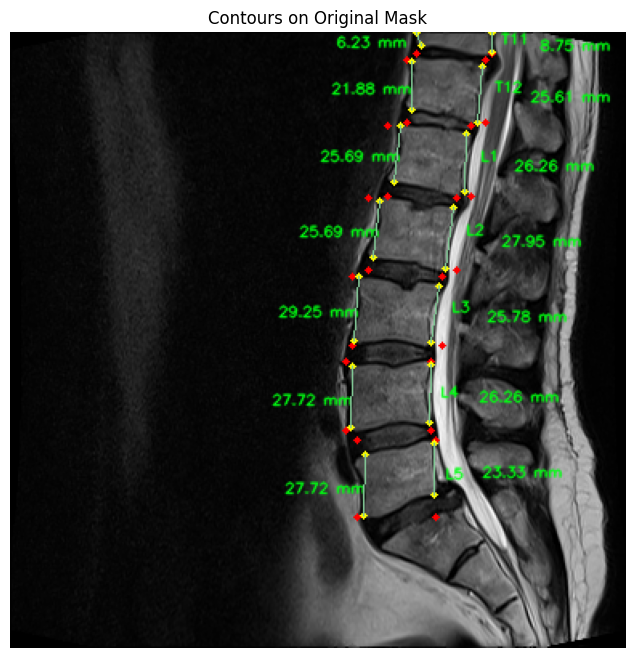

{'Vertebrae': {'L5': {'corner_points': [(221, 263),
    (264, 256),
    (264, 288),
    (220, 301)],
   'distance': {'dist_left_mm': '27.72 mm', 'dist_right_mm': '23.33 mm'}},
  'L4': {'corner_points': [(213, 208), (262, 207), (261, 243), (212, 246)],
   'distance': {'dist_left_mm': '27.72 mm', 'dist_right_mm': '26.26 mm'}},
  'L3': {'corner_points': [(217, 152), (267, 158), (262, 193), (214, 192)],
   'distance': {'dist_left_mm': '29.25 mm', 'dist_right_mm': '25.78 mm'}},
  'L2': {'corner_points': [(230, 105), (276, 109), (271, 147), (226, 140)],
   'distance': {'dist_left_mm': '25.69 mm', 'dist_right_mm': '27.95 mm'}},
  'L1': {'corner_points': [(243, 58), (284, 63), (283, 99), (239, 93)],
   'distance': {'dist_left_mm': '25.69 mm', 'dist_right_mm': '26.26 mm'}},
  'T12': {'corner_points': [(250, 18), (294, 21), (291, 56), (250, 48)],
   'distance': {'dist_left_mm': '21.88 mm', 'dist_right_mm': '25.61 mm'}},
  'T11': {'corner_points': [(253, 0), (300, 0), (300, 12), (256, 8)],
   'di

In [243]:
idx = 130
mask_name_path =mask_list[idx]
image_name_path =images_list[idx]
image_name = os.path.basename(image_name_path).split('.')[0]
pixel_spacing = data[image_name][0]
print(mask_name_path)
print(image_name_path)
print(image_name)
print(pixel_spacing)
mask = load_image(mask_name_path)
image_orig = load_image(image_name_path)
mask_classes = convertToCategoricalMasks(mask)

image_tepm = image_orig.copy()
filtered_mask= getIVDAndPEClass(mask_classes)
contours_dict = getContours(filtered_mask,  structure_names =[   "IVD", 'Vertebrae', "Sacrum"])
drawDistanceOnImage(image_tepm, filtered_mask, contours_dict, pixel_spacing, required_structure_measurements ="Vertebrae", skeletonization= False)

###### Test the API endpoint

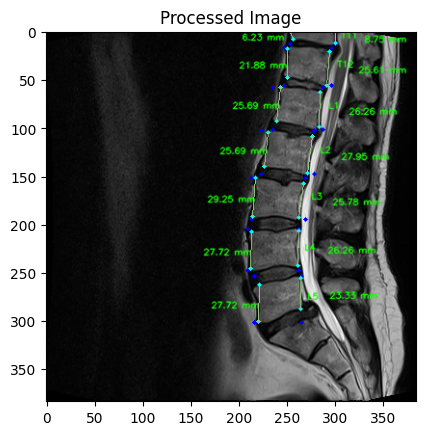

In [244]:
url = "http://127.0.0.1:8000/process_segmentation/"
data = {
    "required_structure_measurements": "Vertebrae",  # Modify as needed ["IVD", "Vertebrae", "Sacrum"]
    "pixel_spacing": 0.72916668653488  # Modify as needed
}
files = {
    "mask_file": open(mask_name_path, "rb"),
    "image_file": open(image_name_path, "rb"), 
}
response = requests.post(url,  files=files, data=data)
response_data = response.json()

# Decode Base64 image
image_base64 = response_data["image"]
image_bytes = base64.b64decode(image_base64)
image_array = np.frombuffer(image_bytes, dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Display the processed image
plt.imshow(image)  # Show the image
plt.title("Processed Image")  # Set the title
plt.show()  # Display the image

##### Angels

In [224]:
def applyAnglesMeasurements(image, mask, contours_dict, pixel_spacing,  required_angle_measurements= ["LLA", "LSA"],
                            contour_colors = None, skeletonization= False):
    spinal_angel_key_points= { 
    "L1": {
        "top_line_points": [],
    },
    "S1": {
        "top_line_points": [],
    },
    "L5": {
        "bottom_line_points": [],
    },
    "LLA": None,
    "LSA": None
    }
    strucure_labels = {
        'Vertebrae': ['L5','L4','L3','L2','L1','T12','T11','T10'],
        'IVD': ['L5-S1','L4-L5','L3-L4','L2-L3','L1-L2','T12-L1','T11-T12','T10-T11'], 
        'Sacrum': ['S1'] 
    }
    
    measurements_dict = {key: {} for key in required_angle_measurements    } 
    contour_colors = {
        'IVD': (255, 0, 0),
        'Vertebrae': (0, 255, 0),
        'Sacrum': (0, 0, 255)
    }
    last_IVD = None
    overlay_image = image.copy()
    # Draw each structure's contours
    for structure, sorted_contours in contours_dict.items():
        if structure in ["Vertebrae", "Sacrum"]:
            color = contour_colors.get(structure, (255, 62, 23))  # Default to white
            structure_cls = SegmentationClass[structure].value
            mask_cls = (mask == structure_cls).astype(np.uint8) * 255
            # plt.imshow(mask_cls)
            for contour, label in zip(sorted_contours[:], strucure_labels[structure]):
                if label in ['L1', 'L5', 'S1' ]:
                    bbox = cv2.boundingRect(contour)
                    # Get convex hull points
                    corrected_corners, raw_corners = getExtremeCorners(overlay_image, mask_cls, structure, last_IVD, contour, bbox ,skeletonization )
                    getSpinalAnglesKeyPoints(label, corrected_corners, spinal_angel_key_points)

    getSpinalAngles(spinal_angel_key_points)
    for angle in required_angle_measurements:
        measurements_dict[angle] = spinal_angel_key_points[angle]
        
    drawAngelsKeyPoints(overlay_image, spinal_angel_key_points, measurements_dict)
    print(measurements_dict)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))  # Convert to RGB for Matplotlib
    plt.title("Contours on Original Mask")
    plt.axis("off")
    plt.show()
    return measurements_dict, #overlay_image, 


def getSpinalAnglesKeyPoints(label, corrected_corners, key_points_dict):
    if label =="S1":
        top_left, top_right = corrected_corners
        key_points_dict[label]["top_line_points"] = [top_left, top_right]
        
    elif label =="L1":
        top_left, top_right, _, _ = corrected_corners
        key_points_dict[label]["top_line_points"] = [top_left, top_right]
        
    elif label =="L5":
        _, _, bottom_left, bottm_right = corrected_corners
        key_points_dict[label]["bottom_line_points"] =  [bottom_left, bottm_right] 
        
def getSpinalAngles(key_points_dict):
    key_points_dict['LLA'] =  getLLA(key_points_dict)
    key_points_dict['LSA'] =  180- getLSA(key_points_dict)
    

def getLLA(key_points_dict):
    L1_top_left = key_points_dict["L1"]["top_line_points"][0]
    L1_top_right = key_points_dict["L1"]["top_line_points"][1]
    S1_top_left = key_points_dict["S1"]["top_line_points"][0]
    S1_top_right = key_points_dict["S1"]["top_line_points"][1]
    angle = angle_between_lines(L1_top_left, L1_top_right, S1_top_left, S1_top_right)
    return angle 
def getLSA(key_points_dict):
    S1_top_left = key_points_dict["S1"]["top_line_points"][0]
    S1_top_right = key_points_dict["S1"]["top_line_points"][1]
    L5_bottom_left = key_points_dict["L5"]["bottom_line_points"][0]
    L5_bottom_right = key_points_dict["L5"]["bottom_line_points"][1]
    angle = angle_between_lines( L5_bottom_left, L5_bottom_right, S1_top_left, S1_top_right)
    return angle 

def drawAngelsKeyPoints(image, key_points_dict, measurements_dict):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.3
    font_thickness = 1
    line_color = (255, 0, 0)
    text_color = (17, 255, 0)  # White
    S1_top_left, S1_top_right = key_points_dict["S1"]["top_line_points"]
    cv2.line(image, S1_top_left, S1_top_right, line_color, 2)  

    text_x, text_y = 10, 20  # Starting position for text
    offest_text = 0
    for key, angle in measurements_dict.items():
        if key == 'LLA':
            L1_top_left, L1_top_right = key_points_dict["L1"]["top_line_points"]
            cv2.line(image, L1_top_left, L1_top_right, line_color, 2) 
            print("angle", angle)
            print("angle", type(angle))
            
            cv2.putText(image, f"LLA: {angle:.2f} deg", (text_x, text_y+ offest_text), font, font_scale, text_color, font_thickness, cv2.LINE_AA)
        elif key == 'LSA':
            L5_bottom_left, L5_bottom_right = key_points_dict["L5"]["bottom_line_points"]
            cv2.line(image, L5_bottom_left, L5_bottom_right, line_color, 2) 
            cv2.putText(image, f"LSA: {angle:.2f} deg", (text_x, text_y + offest_text), font, font_scale, text_color, font_thickness, cv2.LINE_AA)
            # Draw lines
        offest_text += 20

def angle_between_vectors(vec1, vec2):
    """Calculate the angle (in degrees) between two vectors using the dot product."""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    # Avoid division by zero
    if norm1 == 0 or norm2 == 0:
        raise ValueError("Zero-length vector provided.")

    # Compute the angle in radians
    theta_rad = np.arccos(dot_product / (norm1 * norm2))
    
    # Convert to degrees
    return np.degrees(theta_rad)

def points_to_vector(p1, p2):
    """Convert two points into a vector."""
    return np.array([p2[0] - p1[0], p2[1] - p1[1]])

def angle_between_lines(p1, p2, p3, p4):
    """Calculate the angle between two lines defined by their endpoints."""
    vec1 = points_to_vector(p1, p2)
    vec2 = points_to_vector(p3, p4)
    return angle_between_vectors(vec1, vec2)


angle 35.4485960864189
angle <class 'numpy.float64'>
{'LLA': 35.4485960864189, 'LSA': 12.035623806204939}


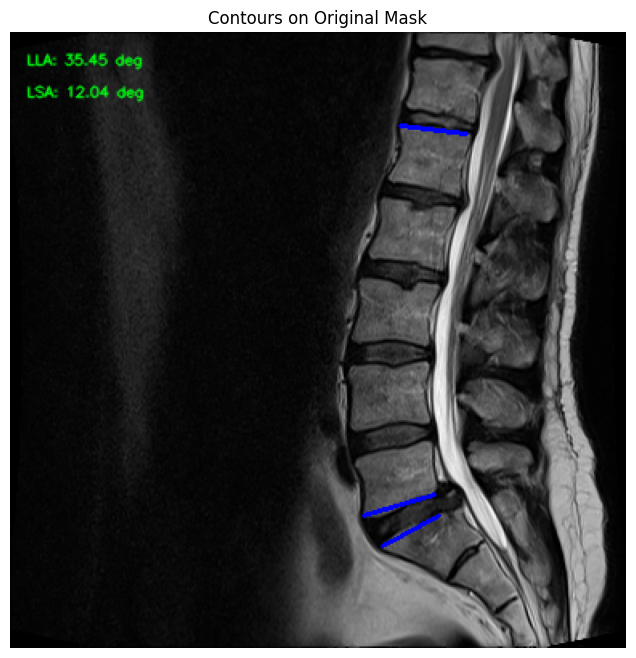

({'LLA': 35.4485960864189, 'LSA': 12.035623806204939},)

In [245]:
image_tepm = image_orig.copy()
filtered_mask= getIVDAndPEClass(mask_classes)
contours_dict = getContours(filtered_mask,  structure_names =[   "IVD", 'Vertebrae', "Sacrum"])
applyAnglesMeasurements(image_tepm, filtered_mask, contours_dict, pixel_spacing, required_angle_measurements= [ "LLA", 'LSA'])

###### Test the API endpoint

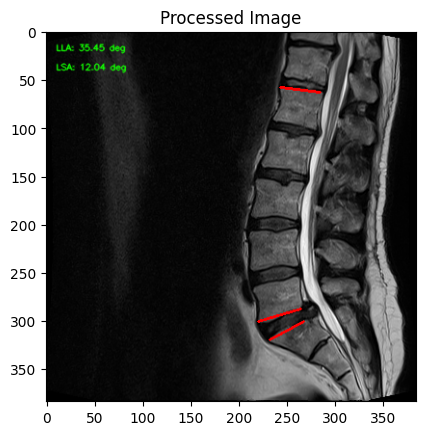

In [237]:
url = "http://127.0.0.1:8000/apply_angle_measurements/"
data = {
    "required_angle_measurements": "LLA,LSA"  # Ensure this is just a string, not a list or something else
}
files = {
    "mask_file": open(mask_name_path, "rb"),
    "image_file": open(image_name_path, "rb")
}

response = requests.post(url, files=files, data=data)
response_data = response.json()
# Decode Base64 image
image_base64 = response_data["image"]
image_bytes = base64.b64decode(image_base64)
image_array = np.frombuffer(image_bytes, dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Display the processed image
plt.imshow(image)  # Show the image
plt.title("Processed Image")  # Set the title
plt.show()  # Display the image

##### Lumber Height

In [249]:
def applySpinalHeightMeasurements(image, mask, contours_dict, pixel_spacing, 
                            contour_colors = None, skeletonization= False):
    spinal_height_key_points= { 
            "L1": {
                "superior_point": None,
                "center_point": None,
            },
            "S1": {
                "superior_point": None,
                "center_point": None,
            },
            "superior_hight": None,
            "center_hight": None
    }
    strucure_labels = {
        'Vertebrae': ['L5','L4','L3','L2','L1','T12','T11','T10'],
        'IVD': ['L5-S1','L4-L5','L3-L4','L2-L3','L1-L2','T12-L1','T11-T12','T10-T11'], 
        'Sacrum': ['S1'] 
    }
    
    contour_colors = {
        'IVD': (255, 0, 0),
        'Vertebrae': (0, 255, 0),
        'Sacrum': (0, 0, 255)
    }
    last_IVD = None
    overlay_image = image.copy()
    # Draw each structure's contours
    for structure, sorted_contours in contours_dict.items():
        if structure in ["Vertebrae", "Sacrum"]:
            color = contour_colors.get(structure, (255, 62, 23))  # Default to white
            structure_cls = SegmentationClass[structure].value
            mask_cls = (mask == structure_cls).astype(np.uint8) * 255
            for contour, label in zip(sorted_contours[:], strucure_labels[structure]):
                if label in ['L1', 'S1' ]:
                    bbox = cv2.boundingRect(contour)
                    # Get convex hull points
                    corrected_corners, raw_corners = getExtremeCorners(overlay_image, mask_cls, structure, last_IVD, contour, bbox ,skeletonization )
                    getSpinalHeightKeyPoint(label, corrected_corners, spinal_height_key_points)

    getSpinalHeight(spinal_height_key_points, pixel_spacing)
    drawSpinalHeight(overlay_image, spinal_height_key_points)
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))  # Convert to RGB for Matplotlib
    plt.title("Contours on Original Mask")
    plt.axis("off")
    plt.show()
    return spinal_height_key_points, overlay_image
    
def getSpinalHeightKeyPoint(label, corrected_corners, key_points_dict):
    if label =="S1":
        top_left, top_right = corrected_corners
    elif label =="L1":
        top_left, top_right, bottom_left, bottm_right = corrected_corners
        
    key_points_dict[label]["superior_point"] = top_left
    # key_points_dict[label]["center_point"] = (x+ w//2 , y + h//2)

def getSpinalHeight(key_points_dict , pixel_spacing):
    key_points_dict["superior_hight"] = getDist(key_points_dict['L1']["superior_point"], key_points_dict['S1']["superior_point"]) *  pixel_spacing
    # key_points_dict["center_hight"] = getDist(key_points_dict['L1']["center_point"], key_points_dict['S1']["center_point"])
    
def drawSpinalHeight(image, key_points_dict):
    # print("key_points_dict")
    # print(key_points_dict)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.3
    font_thickness = 1
    text_color = (17, 255, 0)  # White

    heighest_superior_point = key_points_dict['L1']["superior_point"]
    lowest_superior_point = key_points_dict['S1']["superior_point"]
    # heighest_center_point = key_points_dict['L1']["center_point"]
    # lowest_center_point = key_points_dict['S1']["center_point"]
    sup_height = key_points_dict["superior_hight"]
    sup_height= f"{sup_height:.2f} mm"
    # cent_height = key_points_dict["center_hight"]
    
    text_position = (np.array(key_points_dict['L1']["superior_point"]) + np.array(key_points_dict['S1']["superior_point"]) )//2
    cv2.putText(
    image, str(sup_height), text_position, font, font_scale,
    text_color, font_thickness, cv2.LINE_AA
    )
    # cv2.putText(
    # image, str(cent_height), text_position, font, font_scale,
    # text_color, font_thickness, cv2.LINE_AA
    # )
    cv2.line(image, tuple(heighest_superior_point), tuple(lowest_superior_point), (150, 200, 130), 1)  # Cyan for Left
    # cv2.line(image, tuple(heighest_center_point), tuple(lowest_center_point), (150, 200, 130), 1)  # Cyan for Left
    # cv2.circle(image, tuple(heighest_superior_point), 4, (0, 33, 77), -1)
    # cv2.circle(image, tuple(lowest_superior_point), 4, (0, 33, 77), -1)

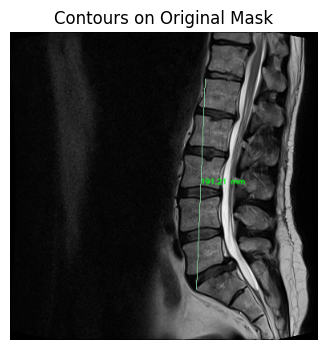

In [251]:
image_tepm = image_orig.copy()
filtered_mask= getIVDAndPEClass(mask_classes)
contours_dict = getContours(filtered_mask,  structure_names =[   "IVD", 'Vertebrae', "Sacrum"])
_ = applySpinalHeightMeasurements(image_tepm, filtered_mask, contours_dict, pixel_spacing)

###### Test the API endpoint

{'L1': {'superior_point': [243, 58], 'center_point': None}, 'S1': {'superior_point': [232, 320], 'center_point': None}, 'superior_hight': '191.21 mm', 'center_hight': None}


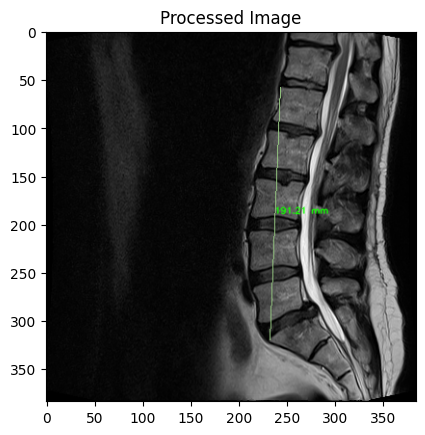

In [269]:
url = "http://127.0.0.1:8000/apply_spinal_height_measurements/"
data = {
    "pixel_spacing": 0.72916668653488  # Modify as needed
}
files = {
    "mask_file": open(mask_name_path, "rb"),
    "image_file": open(image_name_path, "rb"), 
}
response = requests.post(url,  files=files, data=data)
response_data = response.json()
print(response_data['measurements'])
# Decode Base64 image
image_base64 = response_data["image"]
image_bytes = base64.b64decode(image_base64)
image_array = np.frombuffer(image_bytes, dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Display the processed image
plt.imshow(image)  # Show the image
plt.title("Processed Image")  # Set the title
plt.show()  # Display the image

#### Disease Classification

##### Spondylolisithesis

In [299]:
def applySpondylolisithesisClassification(image, mask, contours_dict, pixel_spacing, 
                            contour_colors = None, skeletonization= False):
    spondylolisithesis_key_points= { 
        "L1": None,
        "L2": None,
        "L3": None,
        "L4": None,
        "L5": None,
        "S1": None     
    }
    lumbar_verteberaes = ['S1','L5','L4','L3','L2','L1']
    strucure_labels = {
        'Vertebrae': ['L5','L4','L3','L2','L1','T12','T11','T10'],
        'IVD': ['L5-S1','L4-L5','L3-L4','L2-L3','L1-L2','T12-L1','T11-T12','T10-T11'], 
        'Sacrum': ['S1'] 
    }
    contour_colors = {
        'IVD': (255, 0, 0),
        'Vertebrae': (0, 255, 0),
        'Sacrum': (0, 0, 255)
    }
    last_IVD = None
    overlay_image = image.copy()
    # Draw each structure's contours
    for structure, sorted_contours in contours_dict.items():
        if structure in ["Vertebrae", "Sacrum"]:
            color = contour_colors.get(structure, (255, 62, 23))  # Default to white
            structure_cls = SegmentationClass[structure].value
            mask_cls = (mask == structure_cls).astype(np.uint8) * 255
            for contour, label in zip(sorted_contours[:], strucure_labels[structure]):
                if label in lumbar_verteberaes:
                    bbox = cv2.boundingRect(contour)
                    # Get convex hull points
                    corrected_corners, raw_corners = getExtremeCorners(overlay_image, mask_cls, structure, last_IVD, contour, bbox ,skeletonization )
                    getcentroid(label, corrected_corners, spondylolisithesis_key_points)

    classification_dict = classify_spondylolisthesis(spondylolisithesis_key_points)
    draw_centroid_lines(overlay_image, spondylolisithesis_key_points)
    draw_classification_results(overlay_image, classification_dict)
    print(classification_dict)
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))  # Convert to RGB for Matplotlib
    plt.title("Contours on Original Mask")
    plt.axis("off")
    # plt.show()
    return classification_dict, overlay_image

def classify_spondylolisthesis(spinal_disorder_disease_key_points):
    """Classifies vertebral dislocation based on angular deviation."""
    Vertrical_line_length = 30
    centroids = [spinal_disorder_disease_key_points[vb] for vb in spinal_disorder_disease_key_points if spinal_disorder_disease_key_points[vb] is not None]
    
    angles = [calculate_angle(centroids[i], centroids[i+1], Vertrical_line_length) for i in range(len(centroids)-1)]
    theta_mean = np.mean(angles)
    theta_std = np.std(angles)
    
    classifications = {}
    for i, theta in enumerate(angles):
        if theta < (theta_mean - theta_std):
            classification = "Posterior Displacement"
        elif theta > (theta_mean + theta_std):
            classification = "Anterior Displacement"
        else:
            classification = "Normal"
        classifications[f"L{i+1}"] = {"centroid":centroids[i],"Angle": f"{theta:.2f}", "Classification": classification}
    
    return classifications

def draw_centroid_lines(image, spinal_disorder_disease_key_points):
    """Draws lines between centroids and vertical reference lines."""
    # print("draw_centroid_lines")
    # print("centroid", spinal_disorder_disease_key_points)
    
    for i, vb in enumerate(spinal_disorder_disease_key_points):
        if spinal_disorder_disease_key_points[vb] is None:
            continue
        centroid = spinal_disorder_disease_key_points[vb]
        # print("centroid", centroid)
        cv2.circle(image, centroid, 2, (87, 144, 200), -1)  # Red dot at centroid      
        
        if i < len(spinal_disorder_disease_key_points) - 1:
            next_vb = list(spinal_disorder_disease_key_points.keys())[i + 1]
            if spinal_disorder_disease_key_points[next_vb] is not None:
                next_centroid = spinal_disorder_disease_key_points[next_vb]
                cv2.line(image, centroid, next_centroid, (0, 255, 255), 2)  # Yellow line between centroids
            cv2.line(image, (centroid[0], centroid[1]), (centroid[0], centroid[1] + 30), (0, 255, 0), 2)  # Vertical green line
    
    # return image

def draw_classification_results(image, classifications):
    """Draws classification results as text on the top left side of the image."""
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.3
    font_thickness = 1
    line_color = (255, 0, 0)
    text_color = (17, 255, 0)  # White
    y_offset = 20
    for vb, result in classifications.items():
        text = f"{vb}: {result['Angle']} deg -> {result['Classification']}"
        cv2.putText(image, text, (10, y_offset), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)
        y_offset += 20

def getcentroid(label, corrected_corners, key_points_dict):
    vertebrae_centroid = None
    if label =="S1":
        top_left, top_right = corrected_corners
        vertebrae_centroid = verterbraeMidPoint(top_left, top_right)
    else:
        top_left, top_right, bottom_left, bottm_right = corrected_corners
        vertebrae_centroid = vertebraeCentroid(top_left, top_right, bottom_left, bottm_right)
    key_points_dict[label] = vertebrae_centroid

def verterbraeMidPoint(p1, p2):
    """Computes the midpoint between two points in 2D space."""
    # return ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)
    return (round(p2[0]*0.980), round(p1[1]*0.980) )
    

def vertebraeCentroid(p1, p2, p3, p4):
    """Computes the centroid of four points in 2D space."""
    cx = (p1[0] + p2[0] + p3[0] + p4[0]) // 4
    cy = (p1[1] + p2[1] + p3[1] + p4[1]) // 4
    return (cx, cy)

def calculate_angle(vb1, vb2, Vertrical_line_length):
    """Calculates the angle between the vertical line from vb1 and the line vb1 -> vb2."""
    vec_v = np.array([0, Vertrical_line_length])  # Vertical reference vector
    vec_vb = np.array([vb2[0] - vb1[0], vb2[1] - vb1[1]])
    
    dot_product = np.dot(vec_v, vec_vb)
    norm_v = np.linalg.norm(vec_v)
    norm_vb = np.linalg.norm(vec_vb)
    
    cos_theta = dot_product / (norm_v * norm_vb)
    theta = np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))  # Clip to avoid numerical errors
    
    return theta

{'L1': {'centroid': (262, 78), 'Angle': '14.32', 'Classification': 'Normal'}, 'L2': {'centroid': (250, 125), 'Angle': '11.77', 'Classification': 'Normal'}, 'L3': {'centroid': (240, 173), 'Angle': '3.24', 'Classification': 'Posterior Displacement'}, 'L4': {'centroid': (237, 226), 'Angle': '5.60', 'Classification': 'Normal'}, 'L5': {'centroid': (242, 277), 'Angle': '28.39', 'Classification': 'Anterior Displacement'}}


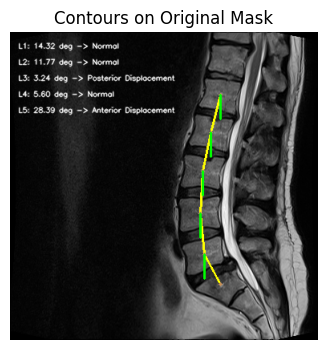

({'L1': {'centroid': (262, 78), 'Angle': '14.32', 'Classification': 'Normal'},
  'L2': {'centroid': (250, 125), 'Angle': '11.77', 'Classification': 'Normal'},
  'L3': {'centroid': (240, 173),
   'Angle': '3.24',
   'Classification': 'Posterior Displacement'},
  'L4': {'centroid': (237, 226), 'Angle': '5.60', 'Classification': 'Normal'},
  'L5': {'centroid': (242, 277),
   'Angle': '28.39',
   'Classification': 'Anterior Displacement'}},
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]

In [300]:
image_tepm = image_orig.copy()
filtered_mask= getIVDAndPEClass(mask_classes)
contours_dict = getContours(filtered_mask,  structure_names =[   "IVD", 'Vertebrae', "Sacrum"])
applySpondylolisithesisClassification(image_tepm, filtered_mask, contours_dict, pixel_spacing)

###### Test the API endpoint

{'L1': {'centroid': [262, 78], 'Angle': '14.32', 'Classification': 'Normal'}, 'L2': {'centroid': [250, 125], 'Angle': '11.77', 'Classification': 'Normal'}, 'L3': {'centroid': [240, 173], 'Angle': '3.24', 'Classification': 'Posterior Displacement'}, 'L4': {'centroid': [237, 226], 'Angle': '5.60', 'Classification': 'Normal'}, 'L5': {'centroid': [242, 277], 'Angle': '28.39', 'Classification': 'Anterior Displacement'}}


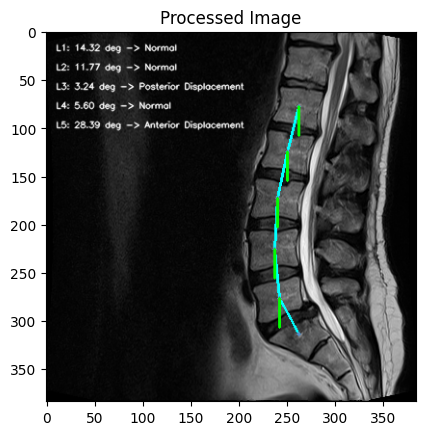

In [303]:
url = "http://127.0.0.1:8000/spondylolisithesis_classification/"
files = {
    "mask_file": open(mask_name_path, "rb"),
    "image_file": open(image_name_path, "rb"), 
}
data = {}
response = requests.post(url,  files=files, data={})
response_data = response.json()
print(response_data['classification'])
# Decode Base64 image
image_base64 = response_data["image"]
image_bytes = base64.b64decode(image_base64)
image_array = np.frombuffer(image_bytes, dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Display the processed image
plt.imshow(image)  # Show the image
plt.title("Processed Image")  # Set the title
plt.show()  # Display the image

##### Lumbar Lordosis

In [307]:
def applyLumbarLordosisClassification(image, mask, contours_dict, pixel_spacing, 
                            contour_colors = None, skeletonization= False):
    lumbar_lordosis_key_points= { 
        "L1": None,
        "L2": None,
        "L3": None,
        "L4": None,
        "L5": None,
        "S1": None     
    }
    lumbar_verteberaes = ['S1','L5','L4','L3','L2','L1']
    strucure_labels = {
        'Vertebrae': ['L5','L4','L3','L2','L1','T12','T11','T10'],
        'IVD': ['L5-S1','L4-L5','L3-L4','L2-L3','L1-L2','T12-L1','T11-T12','T10-T11'], 
        'Sacrum': ['S1'] 
    }
    contour_colors = {
        'IVD': (255, 0, 0),
        'Vertebrae': (0, 255, 0),
        'Sacrum': (0, 0, 255)
    }
    last_IVD = None
    overlay_image = image.copy()
    # Draw each structure's contours
    for structure, sorted_contours in contours_dict.items():
        if structure in ["Vertebrae", "Sacrum"]:
            color = contour_colors.get(structure, (255, 62, 23))  # Default to white
            structure_cls = SegmentationClass[structure].value
            mask_cls = (mask == structure_cls).astype(np.uint8) * 255
            for contour, label in zip(sorted_contours[:], strucure_labels[structure]):
                if label in lumbar_verteberaes:
                    bbox = cv2.boundingRect(contour)
                    # Get convex hull points
                    corrected_corners, raw_corners = getExtremeCorners(overlay_image, mask_cls, structure, last_IVD, contour, bbox ,skeletonization )
                    getcentroid(label, corrected_corners, lumbar_lordosis_key_points)
                    
    lordosis_classification = classify_lordosis(lumbar_lordosis_key_points, overlay_image, pixel_spacing)
    draw_enclosed_area(overlay_image, lumbar_lordosis_key_points )
    # plot_spinal_curve(overlay_image, lumbar_lordosis_key_points )
    draw_classification_results_lordosis(overlay_image, lordosis_classification)
    print(lordosis_classification)
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))  # Convert to RGB for Matplotlib
    plt.title("Contours on Original Mask")
    plt.axis("off")
    # plt.show()
    return lordosis_classification, overlay_image

def compute_centroids(spinal_disorder_disease_key_points):
    """Extracts centroids from the provided dictionary."""
    centroids  = [spinal_disorder_disease_key_points[vb] for vb in spinal_disorder_disease_key_points if spinal_disorder_disease_key_points[vb] is not None]
        # Convert to numpy array and sort by x-coordinates
    # print(centroids)
    # centroids = np.array(sorted(centroids, key=lambda pt: pt[0]))
    centroids = centroidsInterpolation(centroids)
    return centroids

def centroidsInterpolation(centroids):
    """Fits a cubic spline to the spinal curve, handling vertical alignment."""
    centroids = np.array(centroids)
    
    # Extract x and y values
    x, y = centroids[:, 0], centroids[:, 1]

    # Check if the spinal curve is vertical (i.e., x has too much variation)
    # if np.ptp(x) < np.ptp(y):  # If y varies more than x, use y as independent variable
        # y, x = x, y  # Swap axes for interpolation
    swapped = True
    print("swapped")
    # else:
        # swapped = False

    # Ensure y-values are strictly increasing
    # sort_idx = np.argsort(y)
    # y_sorted, x_sorted = y[sort_idx], x[sort_idx]

    # Apply cubic spline interpolation
    cs = CubicSpline(y, x)
    y_new = np.linspace(y.min(), y.max(), 100)
    x_new = cs(y_new)

    # Swap back if needed
    # if swapped:
        # x_new, y_new = y_new, x_new  # Swap back to original order

    return np.array(list(zip(x_new, y_new)), dtype=np.int32)
    
def plot_spinal_curve(image, spinal_disorder_disease_key_points):
    """Draws the spinal curve using cubic spline interpolation."""
    centroids = compute_centroids(spinal_disorder_disease_key_points)
    centroids = np.array(centroids)
    x, y = centroids[:, 0], centroids[:, 1]
    for i in range(len(x) - 1):
        cv2.line(image, (int(x[i]), int(y[i])), (int(x[i + 1]), int(y[i + 1])), (255, 0, 0), 2)  # Blue curve
    return image

def draw_enclosed_area(image, spinal_disorder_disease_key_points):
    """Draws the enclosed area (AR) between the spinal curve and the vertical projection."""
    centroids = compute_centroids(spinal_disorder_disease_key_points)
    # Close the curve by projecting the first and last centroids vertically
    # Get the min and max Y-values for projection
    y_min, y_max = centroids[:, 1].min(), centroids[:, 1].max()
    bottom_projection = [(centroids[0][0], y_min)]
    
    full_contour = np.vstack([centroids, bottom_projection])  # Stack to form a closed shape
    # print("full_contour :",full_contour)
    print("image.shape[:2] :",image.shape)

    # Create mask and fill the polygon
    mask = np.zeros(image.shape, dtype=np.uint8)
    cv2.fillPoly(mask, [full_contour.reshape(-1, 1, 2)], (0,0,255))

    # Overlay the mask onto the original image
    overlay = mask
    # Change overlay color to red (set green and blue to 0, red to 255)
    image[:] = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)


def compute_enclosed_area(image, centroids, pixel_spacing):
    """Computes the enclosed area (AR) between the spinal curve and the vertical projection."""
    # y_min, y_max = centroids[:, 1].min(), centroids[:, 1].max()
    # bottom_projection = [(centroids[0][0], y_min)]
    # full_contour = np.vstack([centroids, bottom_projection])  # Stack to form a closed shape

    # mask = np.zeros(image.shape[:2], dtype=np.uint8)
    # # cv2.fillPoly(mask, [np.array(centroids, dtype=np.int32)], 1) 
    # cv2.fillPoly(mask, [full_contour.reshape(-1, 1, 2)], 1) 
    # plt.imshow(mask)
    # AR = np.sum(mask > 0)  # Count non-zero pixels
    # return AR * 1

    AR = 0
    # Loop through each segment formed by centroids
    for i in range(1, len(centroids)):
        p_i = np.abs(centroids[i][0] - centroids[i-1][0])  # Horizontal distance between centroids (p_i)
        delta_p = centroids[i][1] - centroids[i-1][1]  # Vertical difference between centroids (Δp)
        
        # Update AR with area of trapezoid (p_i * Δp)
        AR += p_i * delta_p * pixel_spacing  # Multiply by pixel_spacing if necessary to get real area

    return round(AR)

def classify_lordosis(spinal_disorder_disease_key_points, image, pixel_spacing, phi=(39, 53)):
    """Classifies lordosis based on area range (phi) adjusted to match clinical criteria."""
    centroids= compute_centroids(spinal_disorder_disease_key_points)
    # centroids_curve = centroidsInterpolation(centroids)
    # image = draw_enclosed_area(image, centroids_curve )
    AR = compute_enclosed_area(image, centroids, pixel_spacing)
    if AR > phi[1]:
        return f"Hyper-lordosis: {AR}"
    elif AR < phi[0]:
        return f"Hypo-lordosis: {AR}"
    else:
        return f"Normal lordosis: {AR}"

def draw_classification_results_lordosis(image, classification):
    """Writes classification results on the top left corner of the image."""
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1
    line_color = (255, 0, 0)
    text_color = (17, 255, 0)  # White
    text_x, text_y = 10, 20  # Starting position for text
    cv2.putText(image, classification, (text_x, text_y), font, font_scale, text_color, font_thickness, cv2.LINE_AA)
    return image

swapped
swapped
image.shape[:2] : (384, 384, 3)
Hyper-lordosis: 90


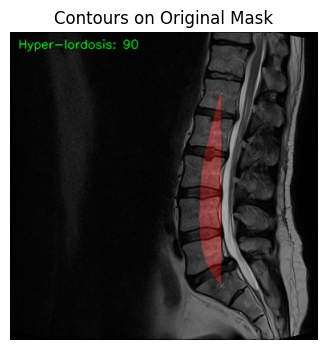

In [309]:
image_tepm = image_orig.copy()
filtered_mask= getIVDAndPEClass(mask_classes)
contours_dict = getContours(filtered_mask,  structure_names =[   "IVD", 'Vertebrae', "Sacrum"])
_= applyLumbarLordosisClassification(image_tepm, filtered_mask, contours_dict, pixel_spacing)

###### Test the API endpoint

Hyper-lordosis: 90


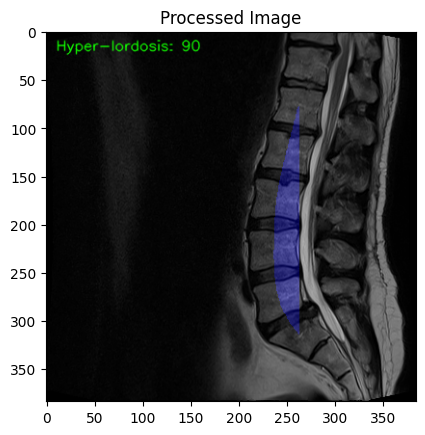

In [312]:
url = "http://127.0.0.1:8000/lumbar_lordosis_classification/"
files = {
    "mask_file": open(mask_name_path, "rb"),
    "image_file": open(image_name_path, "rb"), 
}
data = {
    "pixel_spacing": pixel_spacing
}
response = requests.post(url,  files=files, data=data)
response_data = response.json()
print(response_data['classification'])
# Decode Base64 image
image_base64 = response_data["image"]
image_bytes = base64.b64decode(image_base64)
image_array = np.frombuffer(image_bytes, dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Display the processed image
plt.imshow(image)  # Show the image
plt.title("Processed Image")  # Set the title
plt.show()  # Display the image